# House Price Prediction Using Linear Regression

# Goals

In this little project I will - 
   - Utilize the multiple variables routines
   - Run Gradient Descent on a data set with multiple features
   - Explore the impact of the learning rate *alpha* on gradient descent
   - Improve performance of gradient descent by feature scaling using z-score normalization

# Tools
   - Numpy
   - Matplotlib
   - Pandas

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

OSError: './deeplearning.mplstyle' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

# Problem Statement

The training data set contains many examples with 7 features (beds, baths, size, size_units, lot_size, lot_size_units and zip_code) shown in the table below.

I would like to build a linear regression model using these values so we can then predict the price for other houses - say,  houses from the test dataset.

# Dataset

In [5]:
df = pd.read_csv("./dataset/train.csv")
df.head(3)

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0


In [7]:
df.dtypes

beds                int64
baths             float64
size              float64
size_units         object
lot_size          float64
lot_size_units     object
zip_code            int64
price             float64
dtype: object

## Feature Analysis

### Acre to Square feet

Now that we have the dataset loaded, we can see that some of the lot size is in *sqft* and some of them are in *acre*. So, I will convert the *acre* to *sqft* since we need every data to be on the same format.

In [8]:
m, n = df.shape
for i in range (n):
    if df.iloc[i, 5] == "acre":
        df.iloc[i, 4] = df.iloc[i, 4] * 43560

In [9]:
df.head(3)

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.0,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,13503.6,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.0,sqft,98107,950000.0


Since, every lot size is now on the same data format. Thus we can remove/drop the unit features.

In [10]:
df = df.drop('size_units', axis = 1)
df = df.drop('lot_size_units', axis = 1)

In [11]:
df.head(3)

,beds,baths,size,lot_size,zip_code,price
0,3,2.5,2590.0,6000.0,98144,795000.0
1,4,2.0,2240.0,13503.6,98106,915000.0
2,4,3.0,2040.0,3783.0,98107,950000.0


### Handling missing values

There are so many missing values in the lot-size features. I can -
   - Replace them with Median
   - Replace them with Mean
   - Simply dropping the training example (row)
   
For this particular project I am choosing to replace the blanks with the `mean` of that feature.

In [16]:
df.isnull().sum()

beds          0
baths         0
size          0
lot_size    347
zip_code      0
price         0
dtype: int64

In [17]:
df['lot_size'] = df['lot_size'].fillna(df['lot_size'].mean())

In [20]:
df.isnull().sum()

beds        0
baths       0
size        0
lot_size    0
zip_code    0
price       0
dtype: int64

In [38]:
# Feature and Target Separation
X_train = np.array(df.iloc[:, :-1])
y_train = np.array(df.iloc[:, -1])
X_features = ['beds','baths','size','lot_size','zip_code']

## Feature Scaling

Here, in the dataset, some features have values that are tremendously high and prevent gradient descent from converging to the global minimum. The solution is Feature Scaling.

I know three different techniques:
   - Feature scaling, essentially dividing each positive feature by its maximum value, or more generally, rescale each feature by both its minimum and maximum values using (x-min)/(max-min). Both ways normalizes features to the range of -1 and 1, where the former method works for positive features which is simple and serves well for the lecture's example, and the latter method works for any features.
   - Mean normalization: $x_i := \dfrac{x_i - \mu_i}{max - min} $ 
   - Z-score normalization which we will explore below.
   
I am going for Z-score normalization.

### Z-score Normalization

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

**Implementation**

In [73]:
def z_score_normalize_features(X):
    
    #find the mean of each column/feature
    mu = np.mean(X, axis = 0)  #axis, 0 = column, 1 = row
    
    #find the standard deviation of each/column/featue
    sigma = np.std(X, axis = 0)
    
    #element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma
    
    return (X_norm, mu, sigma)

#or can use functions from sk-learn
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

In [74]:
X_norm, mu, sigma = z_score_normalize_features(X_train)

## Price vs Feature Relation

Let's view the dataset and its features by plotting each feature versus price.

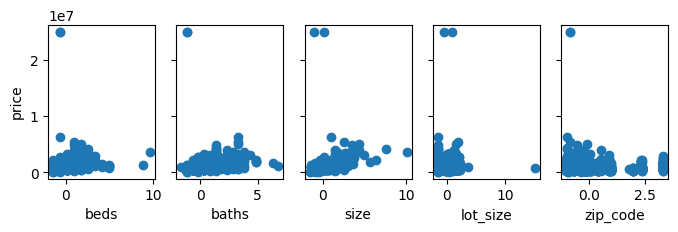

In [77]:
fig, ax = plt.subplots(1, 5, figsize=(8, 2), sharey = True)
for i in range(len(ax)):
    ax[i].scatter(X_norm[:,i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel('price')
plt.show()